## Yet Another Annotated Transformer（私的注釈付きTransformer）
以前メモしておいた内容を元に、Tensorflow公式サイトのTransformerに注釈を付けてみました。<br>
https://www.tensorflow.org/tutorials/text/transformer?hl=ja <BR>
もともと自分で実装していたものがベースにあるので、関数名や変数名が微妙に異なりますがそこは適宜読み替えてください。
    
また、どこまで注釈をつけるか迷いましたが、とりあえずCourseraのSequence Modelsコースを修了した人のレベルくらいに合わせてみたつもりです。<br>
https://www.coursera.org/learn/nlp-sequence-models#syllabus <br>

Transformerを解説した文章なんて巷に山ほど出回っていてだいたい解説し尽くされているとは思いますが、引っかかる箇所は人それぞれですから私個人の視点で注釈をつけることにも多少なりとも価値はあるのではないかと思ったのでここに書き残しておきます。<br>
実際、私もいろんな人が書いた解説を読むことでTransformerを理解してきたので、誰かの参考になれば幸いです。<br>


主な参考文献:<br>
* https://arxiv.org/pdf/1706.03762.pdf
* http://jalammar.github.io/illustrated-transformer/
* https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model
* https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
* https://stats.stackexchange.com/questions/432706/why-use-both-sin-and-cos-functions-in-transformer-positional-encoding
* https://github.com/greentfrapp/attention-primer/blob/master/1_counting-letters/README.md#model

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# ポルトガル語と英語の翻訳データをロードする
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [3]:
# tokenizerを構築する
import tensorflow_text
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [4]:
# 文章をトークン化して開始・終了トークンを追加する
def encode(lang1, lang2):
  # ポルトガル語の開始トークン、終了トークン
  pt_bos_token = tokenizer_pt.vocab_size
  pt_eos_token = tokenizer_pt.vocab_size+1
  # 英語の開始トークン、終了トークン
  en_bos_token = tokenizer_en.vocab_size
  en_eos_token = tokenizer_en.vocab_size+1

  # 文章をトークン化し、開始・終了トークンを前後に追加
  lang1 = [pt_bos_token] + tokenizer_pt.encode(
      lang1.numpy()) + [pt_eos_token]

  lang2 = [en_bos_token] + tokenizer_en.encode(
      lang2.numpy()) + [en_eos_token]

  return lang1, lang2

In [5]:
# encode 関数を グラフモードで使えるようにpy_functionでラップする
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  # 長さは不定なのでNone
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [6]:
# 翻訳タスクのため、ポルトガル語・英語の両方とも文章を途中で切るわけにはいかない。
# どちらも MAX_LENGTH 以内であればTrue, そうでなければFalseを返す関数を用意する
MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [7]:
# trainとvalのデータセットに上記２つの関数が適用されるようにしておく
BUFFER_SIZE = 20000
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    # ptとenのどちらかがMAX_LENGTHよりも長いならそのデータは落とす
    .filter(filter_max_length)
    # 読み取り時のスピードアップのため、データセットをメモリ上にキャッシュする
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))     

In [8]:
# paddingつきのbatchにする
BATCH_SIZE = 64
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE)) # tf.data.experimental.AUTOTUNE == -1  実行中にいい感じに調整する

val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE))

# Transformer の全体図

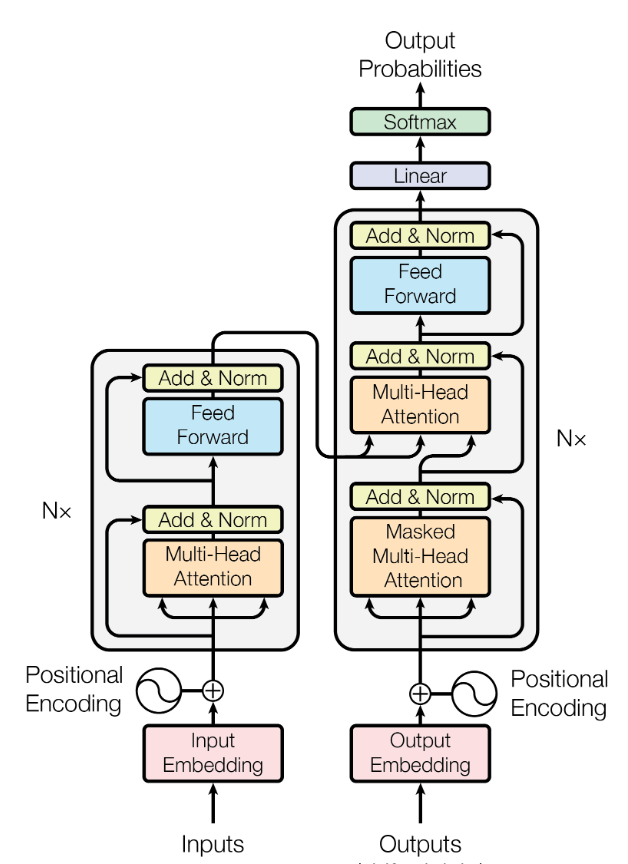

InputsとOutputsには、例えばポルトガル語→英語の翻訳タスクだと、Inputsにポルトガル語の原文が、Outputsに翻訳文である英語が入力される。<br>
左側がEncoder、右側がDecoderと呼ばれる。<br>
Encoder側でエンコードされた情報はDecoderの途中にあるレイヤーに入力され、翻訳中の文章の情報と原文の情報を突き合わせて次の翻訳単語を決定するのに使われる。<br>


## Positional Encodings
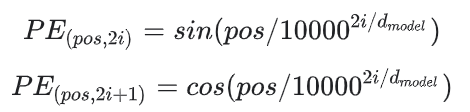

このencodingの目的は、Transformerのinputに単語の位置情報を付加することにある。<br>
TransformerはLSTMなどのRNNとは異なり単語の位置を直接的に表現するための構造がないため、その代わりにこの式によって計算した値を位置を表す情報として使う。<br>

正弦波・余弦波を使う理由：
* 単語の位置ごとにユニークな値を返してくれる
* 入力文字列の長さに影響されず値が常に一定範囲内に収まる
* 単語間の相対的な距離が同じであれば返ってきた値の距離も同じ

正弦波と余弦波の両方を使う理由は、以下の3つ目のWebサイトによると、<br>
この2つをペアにした場合に以下のような線形的な周期性があるため、と説明されている。<br>
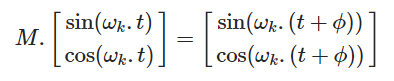


positional encodings についての詳しい解説は以下のURLを参照:
* https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model
* http://jalammar.github.io/illustrated-transformer/
* https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
* https://stats.stackexchange.com/questions/432706/why-use-both-sin-and-cos-functions-in-transformer-positional-encoding

In [9]:
# Positional Encodingsの式中にあるsin, cosの引数に代入する値（角度）を計算する
def get_angles(pos, i, d_model):
  # 2 * (i//2) は 2i と 2i + 1 を双方とも 2i に変換するためのもの
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

# "positional encodings" を計算する
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    # 0::2 もしくは ::2 で、0, 2, 4, 6, ... のようにインデックスを指定できる
    # 1::2 なら1,3,5,7,... のようになる
    angle_rads[:, ::2]  = np.sin(angle_rads[:, ::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # angle_radsを2次元から3次元に拡張する。... はEllipsisという省略記号で、残りの次元をいちいち指定せずにすむ便利な書き方。
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
# 主にScaled Dot Product Attention内のMaskで使われるマスクを作る。
# トークン値が0の位置を"マスク"して出力に影響が及ばないようにするためのもの。
def create_padding_mask(seq):
    # sequence中のデータがゼロのところを１、ゼロじゃないところを0にする
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # アテンション・ロジットにパディングを追加するためさらに次元を追加する
    # ↑ scaled_dot_product_attention で mask を足し算するために必要、という意味
    return seq[:, tf.newaxis, tf.newaxis, :]  # shape => (batch_size, 1, 1, seq_len)

In [11]:
# DecoderがOutputsのデータを”先読み”するのを防止するためのマスク。
# このモデルは答えを前方から1単語ずつ予測するためものであるから、training中であっても現在位置以降の単語は見えてはいけない。
def create_look_ahead_mask(size):
  # band_part は、行列の右上と左下をゼロに置き換えた行列を作って返す関数。
  # https://www.tensorflow.org/api_docs/python/tf/linalg/band_part
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # shape => (seq_len, seq_len)

## Scaled Dot Product Attention

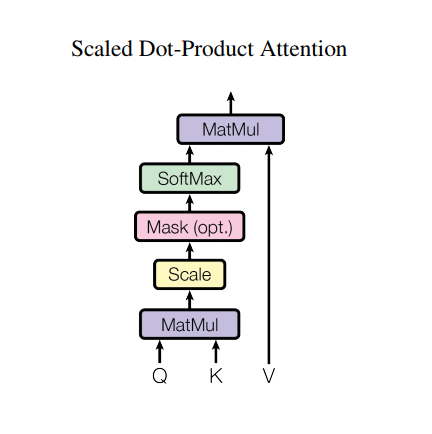

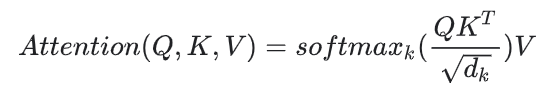

Attention Mechanismは翻訳などのタスクでは単語間の関係性を処理する機能をもつ。<br>
Query, Key, Valueの意味については以下の説明を参照：<br>
https://github.com/greentfrapp/attention-primer/blob/master/1_counting-letters/README.md#model

In [12]:
# 上記の式をプログラムに落とし込む
def scaled_dot_product_attention(q, k, v, mask = None):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    tensordot = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    tensordot = tensordot / tf.math.sqrt(d_k)
    if mask is not None:
        # マスクしたい箇所をすごく小さいマイナス値にする
        tensordot += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(tensordot, axis=-1)
    return tf.matmul(attention_weights, v), attention_weights

# Multi Head Attention
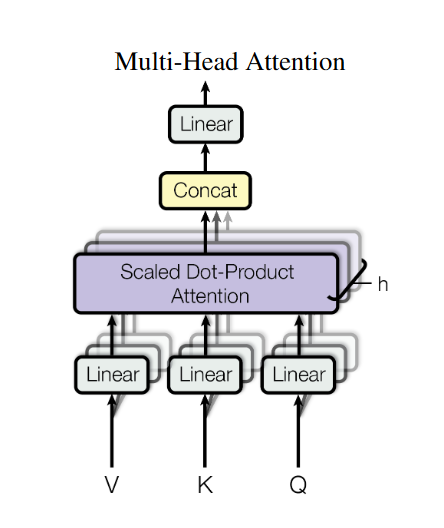

わざわざ複数のAttentionに分割する理由は、入力データを分割して複数のAttentionで計算することで複数の特徴を捉えられるようにするため。<br>

In [13]:
# attentionを複数重ねてMulti Head Attentionを作る
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """最後の次元d_modelを(num_heads, depth)に分割し、
    その後shapeが(batch_size, num_heads, seq_len, depth)となるように変形する。
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, q, k, v, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 論文を読むと分割したheadごとにscaled_dot_product_attentionを計算するように読めるが、
    # プログラム的には行列計算1回で済む
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    # 複数のheadに分割して計算したものを再び一つに結合する
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
    
    return output, attention_weights

In [14]:
# position-wise feed forward networks の実装
def position_wise_feed_forward_nn(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])
    # 以下でも同じ
    inputs = tf.keras.Input(shape=(None, d_model))
    x = tf.keras.layers.Dense(dff, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(d_model)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## EncoderとDecoderの構築
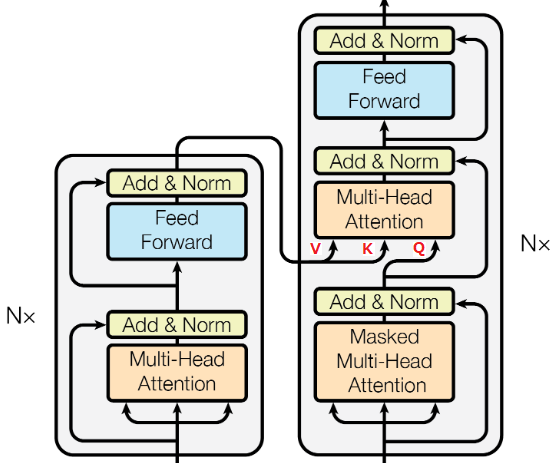

これまで作ってきた関数やクラスを使ってTransformerのEncoderとDecoderを構築する。<br>
EncoderからDecoderのMulti-Head Attentionへの入力は、図にあるようにV, K, Qの順になる。<br>
<!--このような順序になる理由は、このレイヤーで出力したいものが翻訳中の文章に対応する原文の文脈情報であり、その情報を使って次の単語を予測・出力するため。<br>-->

In [15]:
# encoder側の一層分をモジュール化する
class EncoderModule(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads):
        super(EncoderModule, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.position_wise_ff = position_wise_feed_forward_nn(d_model, dff)
        self.dropout1 = tf.keras.layers.Dropout(.1)
        self.dropout2 = tf.keras.layers.Dropout(.1)
        self.normal1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normal2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, x, training, mask):
        output, attention_weights = self.mha(x, x, x, mask=mask)
        # dropout を入れる。Cf. 5.4 Regularization 
        output = self.dropout1(output, training=training)

        # residual connection
        x = x + output
        x = self.normal1(x)
        # Feed Forward
        output = self.position_wise_ff(x)

        # dropout を入れる。
        output = self.dropout2(output, training=training)

        # residual connection
        x = x + output
        x = self.normal2(x)

        return x

# EncoderModule をnum_layersの数だけ重ねてエンコーダー側を作る
class Encoder(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, num_layers, input_vocab_size):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.dff = dff
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_vocab_size = input_vocab_size
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(.1)
        
        self.encoder_modules = [EncoderModule(d_model, dff, num_heads) for _ in range(num_layers)]
        
    def call(self, input, training, mask=None):
        seq_len = tf.shape(input)[1]
        # input を embedding layer に通す
        x = self.embedding(input)
        # Cf. 3.4    Embeddings and Softmax
        x = x * tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        pos_encoding = positional_encoding(self.input_vocab_size, self.d_model)
        x = x + pos_encoding[:, :seq_len, :]

        # dropout を入れる。Cf. 5.4 Regularization 
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.encoder_modules[i](x, training, mask)

        return x

In [16]:
# decoder側の1層分をモジュール化する
class DecoderModule(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads):
        super(DecoderModule, self).__init__()
        
        # Masked Multi-Head Attentionのほう
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # Multi-Head Attentionのほう
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.position_wise_ff = position_wise_feed_forward_nn(d_model, dff)
        self.dropout1 = tf.keras.layers.Dropout(.1)
        self.dropout2 = tf.keras.layers.Dropout(.1)
        self.dropout3 = tf.keras.layers.Dropout(.1)
        self.normal1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normal2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normal3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, x, encoder_output, training, look_ahead_mask=None, padding_mask=None):
        output, attention_weights = self.mha1(x, x, x, mask=look_ahead_mask)
        # dropout を入れる。Cf. 5.4 Regularization 
        output = self.dropout1(output, training=training)

        # residual connection
        x = x + output
        x = self.normal1(x)

        # multi-head attention with encoder output
        # kとvにはencoder_output, q には x （decoder側のoutput）が入る。
        output, attention_weights = self.mha2(x, encoder_output, encoder_output, mask=padding_mask)

        # dropout を入れる。
        output = self.dropout2(output, training=training)

        # residual connection
        x = x + output
        x = self.normal2(x)

        # Feed Forward
        output = self.position_wise_ff(x)

        # dropout を入れる。
        output = self.dropout3(output, training=training)

        # residual connection
        x = x + output
        x = self.normal3(x)

        return x

# DecoderModule をnum_layersの数だけ重ねてデコーダー側を作る
class Decoder(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, num_layers, output_vocab_size):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.dff = dff
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.output_vocab_size = output_vocab_size
        
        self.embedding = tf.keras.layers.Embedding(output_vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(.1)
        
        self.decoder_modules = [DecoderModule(d_model, dff, num_heads) for _ in range(num_layers)]
        
    def call(self, input, encoder_output, training, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(input)[1]
        # input を embedding layer に通す
        x = self.embedding(input)
        x = x * tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # pos encoding の値を足す
        pos_encoding = positional_encoding(self.output_vocab_size, self.d_model)
        x = x + pos_encoding[:, :seq_len, :]

        # dropout を入れる。
        x = self.dropout(x, training=training)

        # num_layers の分だけデコーダーモジュールを重ねる
        for i in range(self.num_layers):
            x = self.decoder_modules[i](x, encoder_output, training, look_ahead_mask, padding_mask)
        return x


In [17]:
# EncoderとDecoderを合体させてTransformerを作る
class Transformer(tf.keras.Model):
    def __init__(self, num_layer, num_heads, d_model, dff, input_vocab_size, target_vocab_size):
        super(Transformer, self).__init__()
        self.num_layer = num_layer
        self.d_model = d_model
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.encoder = Encoder(d_model=d_model, dff=dff, num_heads=num_heads, num_layers=num_layer, input_vocab_size=input_vocab_size)
        self.decoder = Decoder(d_model=d_model, dff=dff, num_heads=num_heads, num_layers=num_layer, output_vocab_size=target_vocab_size)
        self.dense = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input_seq, output_seq, training):
        padding_mask = create_padding_mask(input_seq)
        encoder_output = self.encoder(input_seq, training=training, mask=padding_mask)
        
        look_ahead_mask = create_look_ahead_mask(tf.shape(output_seq)[1])
        dec_target_padding_mask = create_padding_mask(output_seq)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
        decoder_output = self.decoder(output_seq, encoder_output, training=training, look_ahead_mask=combined_mask, padding_mask=padding_mask)
        lineared = self.dense(decoder_output)
        return lineared


In [18]:
# learning rate をtraining step数に応じて変化させる
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# loss を計算する関数を作る
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)


In [19]:
# transformerなどのオプジェクト作成
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

transformer = Transformer(num_layer=num_layers, num_heads=num_heads, dff=dff, d_model=d_model, input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size)
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [20]:
# training する
# チェックポイントを保存するための設定
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# チェックポイントが存在したなら、最後のチェックポイントを復元
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  # 正解データはBOSの次の単語から。
  tar_real = tar[:, 1:]
  # decoderにinputするデータは、BOSで始まる。長さを合わせるために一番うしろの単語を削る。
  tar_inp = tar[:, :-1]

  with tf.GradientTape() as tape:
    predictions = transformer(inp, tar_inp, training=True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

EPOCHS = 20
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 10 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))


  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3430 Accuracy 0.0000
Epoch 1 Batch 10 Loss 4.3098 Accuracy 0.0000
Epoch 1 Batch 20 Loss 4.2520 Accuracy 0.0000
Epoch 1 Batch 30 Loss 4.2255 Accuracy 0.0000
Epoch 1 Batch 40 Loss 4.2051 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.1958 Accuracy 0.0000
Epoch 1 Batch 60 Loss 4.2035 Accuracy 0.0006
Epoch 1 Batch 70 Loss 4.1945 Accuracy 0.0036
Epoch 1 Batch 80 Loss 4.1939 Accuracy 0.0065
Epoch 1 Batch 90 Loss 4.1891 Accuracy 0.0088
Epoch 1 Batch 100 Loss 4.1689 Accuracy 0.0105
Epoch 1 Batch 110 Loss 4.1536 Accuracy 0.0120
Epoch 1 Batch 120 Loss 4.1478 Accuracy 0.0132
Epoch 1 Batch 130 Loss 4.1321 Accuracy 0.0143
Epoch 1 Batch 140 Loss 4.1225 Accuracy 0.0152
Epoch 1 Batch 150 Loss 4.1134 Accuracy 0.0159
Epoch 1 Batch 160 Loss 4.0993 Accuracy 0.0166
Epoch 1 Batch 170 Loss 4.0842 Accuracy 0.0172
Epoch 1 Batch 180 Loss 4.0628 Accuracy 0.0178
Epoch 1 Batch 190 Loss 4.0563 Accuracy 0.0184
Epoch 1 Batch 200 Loss 4.0465 Accuracy 0.0189
Epoch 1 Batch 210 Loss 4.0335 Accuracy 0.0195

In [21]:
# 実際に翻訳してみる
def generate_translation(input_seq):
    input_tensor = tf.constant(np.array(input_seq), shape=(1,MAX_LENGTH))
    
    start_code = tokenizer_en.vocab_size
    end_code   = tokenizer_en.vocab_size + 1
    cnt = 0
    output_seq = [start_code]
    while cnt < MAX_LENGTH:
        cnt += 1
        output_tensor = tf.constant(output_seq, shape=(1, len(output_seq)), dtype="int64")
        
        result = transformer(input_tensor, output_tensor, training=False)
        next_word_id = np.argmax(result[0][-1])
        if end_code == next_word_id:
            break
        output_seq.append(next_word_id)
    output_seq = np.array(output_seq)
    output_seq = output_seq[output_seq < start_code]
    
    return output_seq
        
# とりあえずinputデータから一つ拾ってきてそれを翻訳させてみる
pt_str = inp[0]
pt_str_len = int(tf.shape(pt_str))
translated_seq = generate_translation(tf.pad(pt_str, [[0, MAX_LENGTH - pt_str_len]])) 
nparr = pt_str.numpy()
nparr[(nparr >= tokenizer_pt.vocab_size)] = 0
nparr = nparr[nparr != 0]

tokenizer_pt.decode(nparr), tokenizer_en.decode(translated_seq)

('estes estremófilos mostram-nos que a vida pode existir em muitos outros ambientes .',
 'these early modules show us that life can exist in many other environments .')